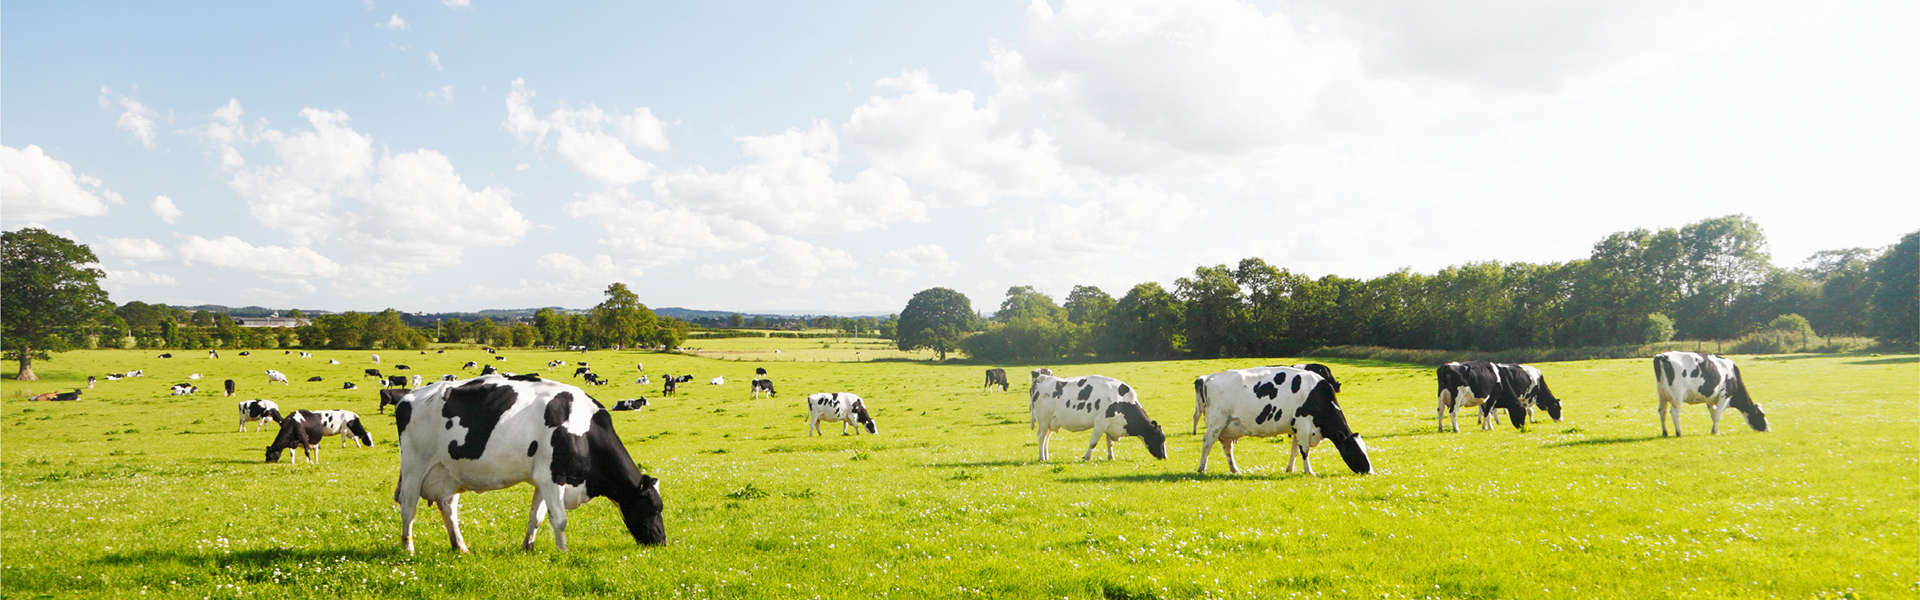

János gazda ipari kémkedésre szánja el magát, de sajnos csak a helyi nyugdíjasotthon számítógépes tanfolyamára tud besurranni, hogy hackerré képezze magát. Miután úgy érzi, hogy már ért a modern technika alapjaihoz baráti iszogatást szervez a szomszéd gazdával, majd besurran annak dolgozószobájába. Hiányos ismereteivel az álozat adatbázisát feltörni nem tudja, de sikerül kimentenie az állatok rekordjaihoz kapcsolt profilképeket. Mivel rengeteg állatról talált képet, felbérelt téged, hogy írj neki egy scriptet, ami összesíti az illegálisan szerzett információt és felfedi Jánosnak Ferenc gazda állatállományának összetételét. Döntsd el minden képről, hogy milyen állat található rajta, majd összesítsd a lenti textboxban ebben a sorrendben: [ló, tehén, juh, tyúk, kutya, macska]

Érdemes GPU runtime-ra állítani!

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

print(tf.__version__)

2.14.0


In [2]:
!gdown 1bKi6-RUkoOQhUfFziJzSStQoIJlDUBPH
!unzip /content/janosgazda_data.zip
!gdown 1vNHDty3FqcZ_pQNSry2c9uoZMX04YlbY


Downloading...
From: https://drive.google.com/uc?id=1bKi6-RUkoOQhUfFziJzSStQoIJlDUBPH
To: /content/janosgazda_data.zip
100% 12.1M/12.1M [00:00<00:00, 82.7MB/s]
Archive:  /content/janosgazda_data.zip
   creating: janosgazda/
  inflating: __MACOSX/._janosgazda   
  inflating: janosgazda/.DS_Store    
  inflating: __MACOSX/janosgazda/._.DS_Store  
   creating: janosgazda/stolen_data/
  inflating: __MACOSX/janosgazda/._stolen_data  
   creating: janosgazda/stolen_data/farm_db/
  inflating: __MACOSX/janosgazda/stolen_data/._farm_db  
  inflating: janosgazda/stolen_data/farm_db/horse24.jpeg  
  inflating: __MACOSX/janosgazda/stolen_data/farm_db/._horse24.jpeg  
  inflating: janosgazda/stolen_data/farm_db/cow54.jpeg  
  inflating: __MACOSX/janosgazda/stolen_data/farm_db/._cow54.jpeg  
  inflating: janosgazda/stolen_data/farm_db/cow42.jpeg  
  inflating: __MACOSX/janosgazda/stolen_data/farm_db/._cow42.jpeg  
  inflating: janosgazda/stolen_data/farm_db/sheep16.jpg  
  inflating: __MACOSX/janosg

In [3]:
num_classes = 10

# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB2(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

augment = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal"),
                              layers.experimental.preprocessing.RandomRotation(0.2),
                              layers.experimental.preprocessing.RandomZoom(0.2),
                              layers.experimental.preprocessing.RandomContrast(0.2),],
                              name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.load_weights('/content/weights.h5')



31790344/31790344 [==============================] - 0s 0us/step


In [12]:
pred_path = "/content/janosgazda/stolen_data/farm_db"

classes = {0: 'butterfly',
            1: 'cat',
            2: 'cow',
            3: 'dog',
            4: 'elephant',
            5: 'hen',
            6: 'horse',
            7: 'sheep',
            8: 'spider',
            9: 'squirrel'}

class_counts = {i: 0 for i in range(num_classes)}

In [13]:
for filename in os.listdir(pred_path):
    img_path = os.path.join(pred_path, filename)
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array.reshape(1, 224, 224, 3))
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    class_counts[predicted_class] += 1


for class_index, count in class_counts.items():
    class_name = classes[class_index]
    print(f"{class_name}: {count} images")

1/1 [==============================] - 0s 38ms/step
butterfly: 0 images
cat: 4 images
cow: 59 images
dog: 7 images
elephant: 0 images
hen: 47 images
horse: 28 images
sheep: 77 images
spider: 0 images
squirrel: 0 images


In [10]:
for filename in os.listdir(pred_path):
    class_name = filename.split("xx")[0]

    if class_name in class_counts:
        class_counts[class_name] += 1

for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

0: 0 images
1: 4 images
2: 59 images
3: 7 images
4: 0 images
5: 47 images
6: 28 images
7: 77 images
8: 0 images
9: 0 images
